In [1]:
import numpy as np
import seaborn as sns
import tensorflow.keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D, BatchNormalization
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import load_model # to save the model
from tensorflow.keras import layers, losses
from tensorflow.random import set_seed
from tensorflow.keras import regularizers 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization, Input
from keras.models import Model
from keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
image_array = np.load('../input/data-amazon-product-image-250-new/image_array.npy')
label_array = np.load('../input/data-amazon-product-image-250-new/label_array.npy')

In [3]:
train_images, test_images, train_labels, test_labels=train_test_split(image_array, label_array,
                                                                      test_size=0.1, random_state=42)
train_images, val_images, train_labels, val_labels=train_test_split(train_images, train_labels,
                                                                      test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0

print('Number of   training samples : {}'.format(train_images.shape[0]))
print('Number of validation samples : {}'.format(val_images.shape[0]))
print('Number of       test samples : {}'.format(test_images.shape[0]))

Number of   training samples : 3592
Number of validation samples : 899
Number of       test samples : 500


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
from tensorflow.keras.optimizers import Adam
model = Sequential(name = 'VGG16_by_Hoang')

model.add(Conv2D(input_shape = (224,224,3), filters = 64, kernel_size = (3,3), padding = 'same',
                 activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation = 'softmax'))

model.compile(optimizer=Adam(lr = 0.00001), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
model.summary()

2022-10-14 06:35:08.271458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:35:08.370889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:35:08.371953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 06:35:08.374856: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "VGG16_by_Hoang"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)  

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
history = model.fit(train_images, train_labels, batch_size = 16 , epochs = 50,
                    validation_data = (val_images,  val_labels),verbose = 1)

2022-10-14 06:35:12.753399: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-14 06:35:15.268130: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-14 06:35:16.976913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-10-14 06:35:19.276514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 [==============================] - ETA: 0s - loss: 4.3156 - accuracy: 0.0668

2022-10-14 06:35:58.811551: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.
2022-10-14 06:35:59.441819: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.


225/225 [==============================] - 48s 170ms/step - loss: 4.3156 - accuracy: 0.0668 - val_loss: 3.2093 - val_accuracy: 0.0679
Epoch 2/50
225/225 [==============================] - 32s 142ms/step - loss: 3.2717 - accuracy: 0.1147 - val_loss: 3.0864 - val_accuracy: 0.0779
Epoch 3/50
225/225 [==============================] - 32s 143ms/step - loss: 2.9610 - accuracy: 0.1590 - val_loss: 2.7268 - val_accuracy: 0.1780
Epoch 4/50
225/225 [==============================] - 32s 142ms/step - loss: 2.7804 - accuracy: 0.1837 - val_loss: 2.6661 - val_accuracy: 0.2013
Epoch 5/50
225/225 [==============================] - 32s 142ms/step - loss: 2.6622 - accuracy: 0.2135 - val_loss: 2.6201 - val_accuracy: 0.2369
Epoch 6/50
225/225 [==============================] - 32s 142ms/step - loss: 2.5347 - accuracy: 0.2578 - val_loss: 2.5862 - val_accuracy: 0.2425
Epoch 7/50
225/225 [==============================] - 32s 142ms/step - loss: 2.4474 - accuracy: 0.2790 - val_loss: 2.5420 - val_accuracy: 0.2

In [7]:
print("Loss of the model is - " , model.evaluate(test_images, test_labels)[0])
print("Accuracy of the model is - " , model.evaluate(test_images, test_labels)[1]*100 , "%")

2022-10-14 07:02:13.112474: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301056000 exceeds 10% of free system memory.


16/16 [==============================] - 6s 200ms/step - loss: 3.5882 - accuracy: 0.3000
Loss of the model is -  3.588209390640259
16/16 [==============================] - 1s 71ms/step - loss: 3.5882 - accuracy: 0.3000
Accuracy of the model is -  30.000001192092896 %


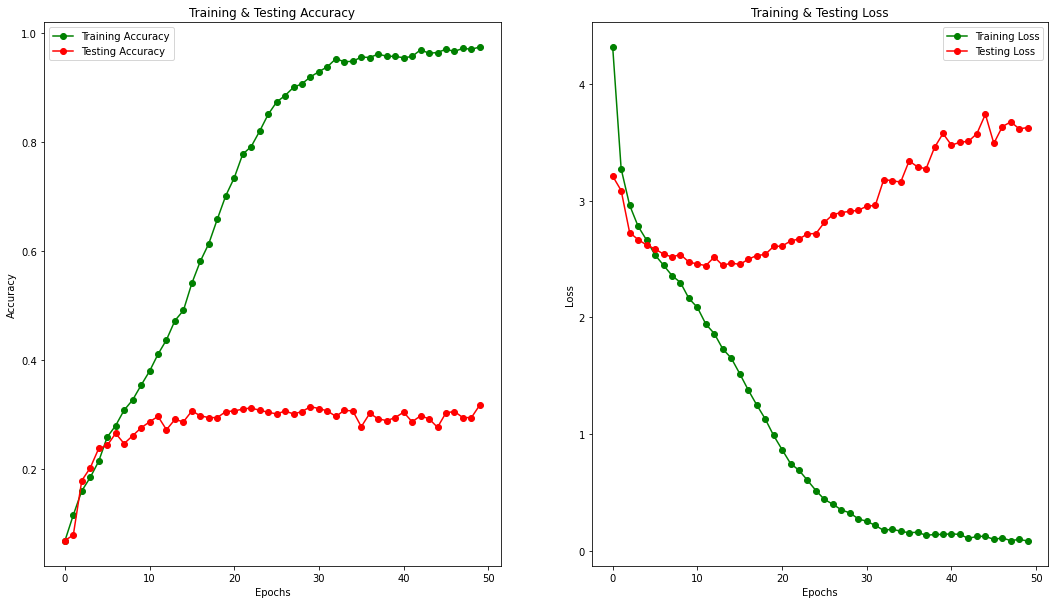

In [8]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(18,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [9]:
predictions = np.argmax(model.predict(test_images), axis=1) # this will pick the value in an array having the maximum score
predictions[:10]

array([10, 11,  7, 15, 10,  8,  8, 19,  5, 14])

In [10]:
categories = ['Baby','Home Improvement','Pet Supplies','Kitchen & Dining',
              'Automotive','Computers','Cell Phones & Accessories',
              'Health & Personal Care','Beauty','Grocery & Gourmet Food',
              'Patio, Lawn & Garden','Arts, Crafts & Sewing',
              'Musical Instruments','Home &amp; Kitchen','Clothing',
              'Jewelry','Electronics','Camera & Photo','Watches','Shoes']

In [11]:
print(classification_report(test_labels.astype(str), predictions.astype(str), target_names = categories))

                           precision    recall  f1-score   support

                     Baby       0.58      0.32      0.42        34
         Home Improvement       0.20      0.04      0.06        28
             Pet Supplies       0.22      0.33      0.27        24
         Kitchen & Dining       0.15      0.30      0.20        20
               Automotive       0.26      0.26      0.26        23
                Computers       0.04      0.06      0.05        16
Cell Phones & Accessories       0.38      0.24      0.29        21
   Health & Personal Care       0.68      0.59      0.63        32
                   Beauty       0.27      0.33      0.30        21
   Grocery & Gourmet Food       0.42      0.53      0.47        15
     Patio, Lawn & Garden       0.58      0.62      0.60        29
    Arts, Crafts & Sewing       0.72      0.65      0.68        20
      Musical Instruments       0.33      0.18      0.23        34
       Home &amp; Kitchen       0.11      0.05      0.07     

<AxesSubplot:>

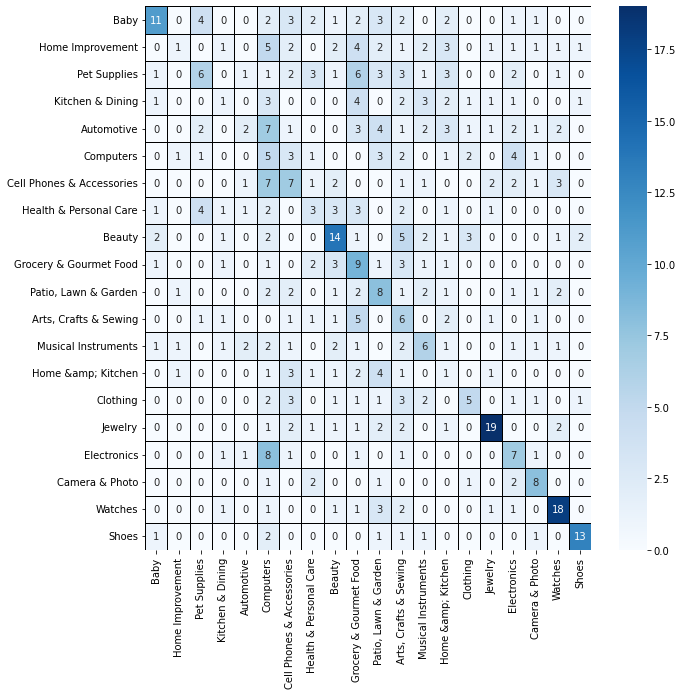

In [12]:
cm = confusion_matrix(test_labels,predictions)

cm = pd.DataFrame(cm , index = categories , columns = categories)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', 
            xticklabels = categories , yticklabels =categories)